<a href="https://colab.research.google.com/github/EChin179/machinelearning/blob/master/self-driving-car.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# importing and cloning data from github
!git clone https://github.com/EChin179/track

Cloning into 'track'...
remote: Enumerating objects: 2, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 64008 (delta 0), reused 0 (delta 0), pack-reused 64006
Receiving objects: 100% (64008/64008), 820.77 MiB | 35.64 MiB/s, done.
Resolving deltas: 100% (4/4), done.
Checking out files: 100% (12160/12160), done.


In [0]:
# lists files and items in track
!ls track

driving_log.csv  IMG


In [0]:
!pip3 install imgaug

In [0]:
# importing various libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Convolution2D, MaxPooling2D, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from imgaug import augmenters as iaa
import cv2
import pandas as pd
import ntpath
import random

Using TensorFlow backend.


In [0]:
# Retrieves and reads data in track
datadir = 'track'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(datadir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', -1)

In [0]:
# resets all image names in table into just the tail end of the directory
def path_leaf(path):
  head, tail = ntpath.split(path)
  return tail
data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)
data.head()

center  ...     speed
0  center_2018_07_16_17_11_43_382.jpg  ...  0.649786
1  center_2018_07_16_17_11_43_670.jpg  ...  0.627942
2  center_2018_07_16_17_11_43_724.jpg  ...  0.622910
3  center_2018_07_16_17_11_43_792.jpg  ...  0.619162
4  center_2018_07_16_17_11_43_860.jpg  ...  0.615438

[5 rows x 7 columns]

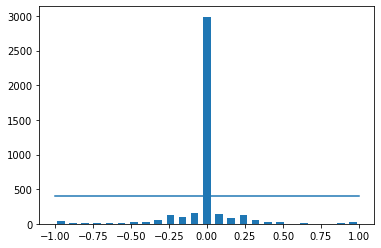

In [0]:
# plotting the steering angles for each set of images on a histogram to visualize the distribution
num_bins = 25
# samples_per_bin is used to reject all values above samples_per_bin, so our data is not skewed to steer only straight at all times
samples_per_bin = 400
hist, bins = np.histogram(data['steering'], num_bins)
# centering bins around 0 instead of 0.04
center = (bins[:-1] + bins[1:]) * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

total data: 4053
removed: 2590
remaining: 1463


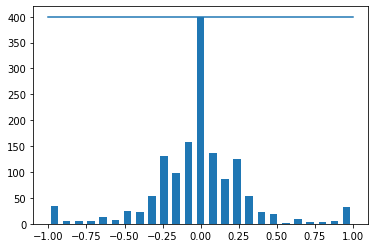

In [0]:
print('total data:', len(data))

# actually putting each image for each steering angle into a bin
remove_list = []
for j in range(num_bins):
  list_ = []

  # iterates through each steering double and checks if the steering double belongs into the jth bin
  for i in range(len(data['steering'])):
    if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j+1]:
      list_.append(i)

  # shuffling the list because if we simply cut off a portion of the data, we lose a portion of the track
  # shuffling lets us limit the data to 200 to get a more uniform shape while retaining information from all parts of the track
  list_ = shuffle(list_)
  # isolating everything that goes beyond the threshold
  list_ = list_[samples_per_bin:]
  remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

In [0]:
# print(data.iloc[1])

# places center images and steering floats in into lists, allowing us to reference them
def load_img_steering(datadir, df):
  image_path = []
  steering = []
  for i in range(len(data)):
    # selects the ith row of data - you can uncomment the print statement at the top to see iloc in action
    indexed_data = data.iloc[i]
    center, left, right = indexed_data[0], indexed_data[1], indexed_data[2]
    image_path.append(os.path.join(datadir, center.strip()))
    steering.append(float(indexed_data[3]))
  image_paths = np.asarray(image_path)
  steerings = np.asarray(steering)
  return image_paths, steerings

image_paths, steerings = load_img_steering(datadir + '/IMG', data)


In [0]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)
print('Training Samples: {}\nValid Samples: {}'.format(len(X_train), len(X_valid)) )

Training Samples: 1170
Valid Samples: 293


Text(0.5, 1.0, 'Validation set')

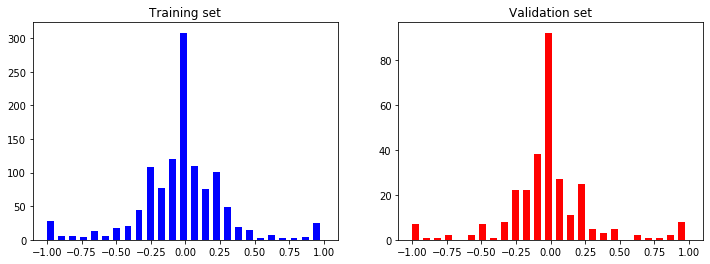

In [0]:
# plotting two historgams, hence 1 row 2 cols
# axes is an array of axes objects
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
axes[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axes[0].set_title('Training set')
axes[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axes[1].set_title('Validation set')

In [0]:
# Image Augmentation #1: Zoom
def zoom(image):
  # can zoom up to 30%
  zoom = iaa.Affine(scale=(1, 1.3))
  image = zoom.augment_image(image)
  return image

Text(0.5, 1, 'Zoomed image')

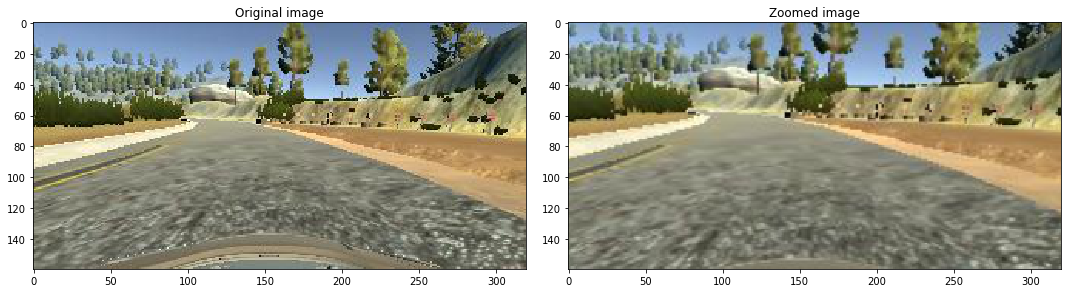

In [0]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image')
axs[1].imshow(zoomed_image)
axs[1].set_title('Zoomed image')

In [0]:
# Image Augmentation #2: Pan
def pan(image):
  # will select a random percentage of pan within defined range -0.1 to 0.1 for each augmented image
  pan = iaa.Affine(translate_percent={'x':(-0.1, 0.1), 'y':(-0.1, 0.1)})
  image = pan.augment_image(image)
  return image

Text(0.5, 1, 'Panned image')

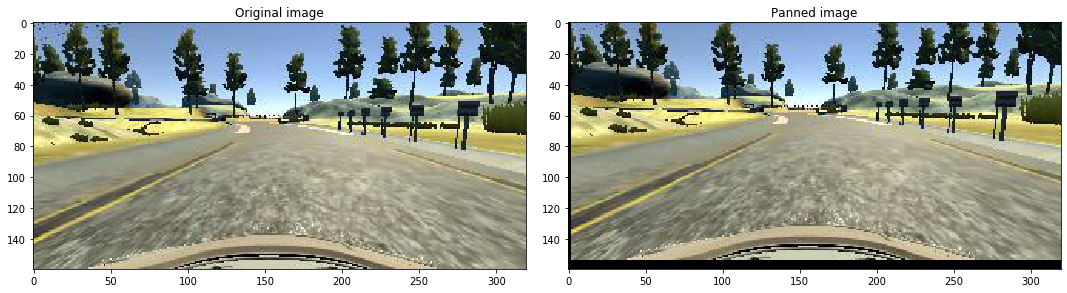

In [0]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image')
axs[1].imshow(panned_image)
axs[1].set_title('Panned image')

In [0]:
# Image Augmentation #3: Brightness
def img_random_brightness(image):
  brightness = iaa.Multiply((0.2, 1.2))
  image = brightness.augment_image(image)
  return image

Text(0.5, 1, 'Brightness altered image')

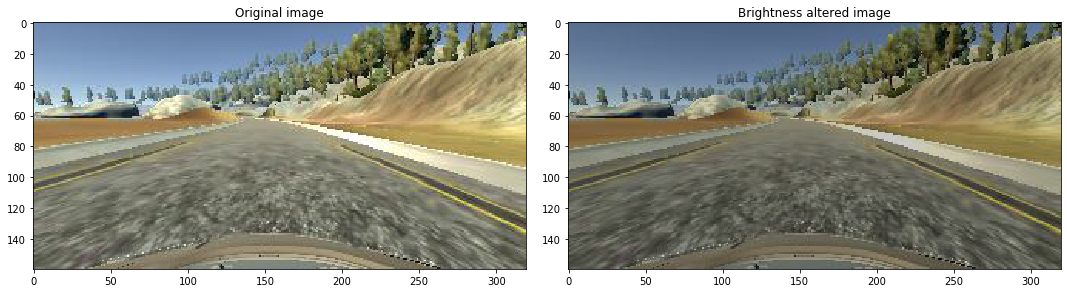

In [0]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightness_altered_image = img_random_brightness(original_image)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image')
axs[1].imshow(brightness_altered_image)
axs[1].set_title('Brightness altered image')

In [0]:
# Image Augmentation #4: Flip
def img_random_flip(image, steering_angle):
  # value of 1 flips it horizontally
  image = cv2.flip(image, 1)
  # steering angle needs to be flipped too, or else you're going to be driving in the opposite direction
  steering_angle = -steering_angle
  return image, steering_angle

Text(0.5, 1, 'Flipped image - Steering Angle: -0.0')

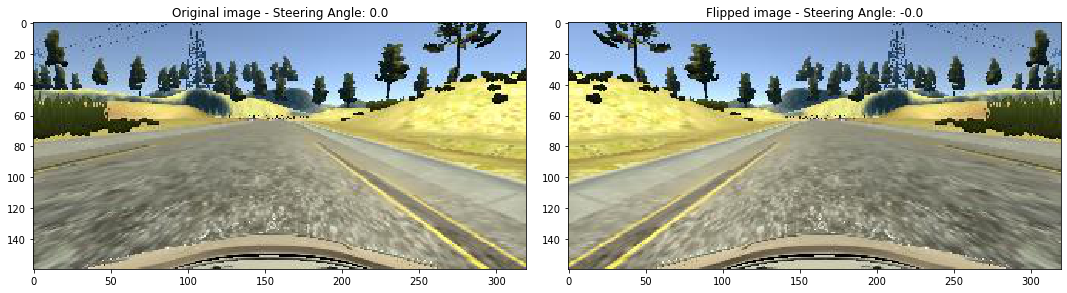

In [0]:
# to ensure that we have the correct corresponding angle and image when testing the img_random_flip function out
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(original_image)
axs[0].set_title('Original image - Steering Angle: ' + str(steering_angle))
axs[1].imshow(flipped_image)
axs[1].set_title('Flipped image - Steering Angle: ' + str(flipped_steering_angle))

In [0]:
def random_augment(image, steering_angle):
  image = mpimg.imread(image)
  # each augmentation should only be applied to 50% of the augmented images
  if np.random.rand() < 0.5:
    image = pan(image)
  if np.random.rand() < 0.5:
    image = zoom(image)
  if np.random.rand() < 0.5:
    image = img_random_brightness(image)
  if np.random.rand() < 0.5:
    image, steering_angle = img_random_flip(image, steering_angle)
  return image, steering_angle

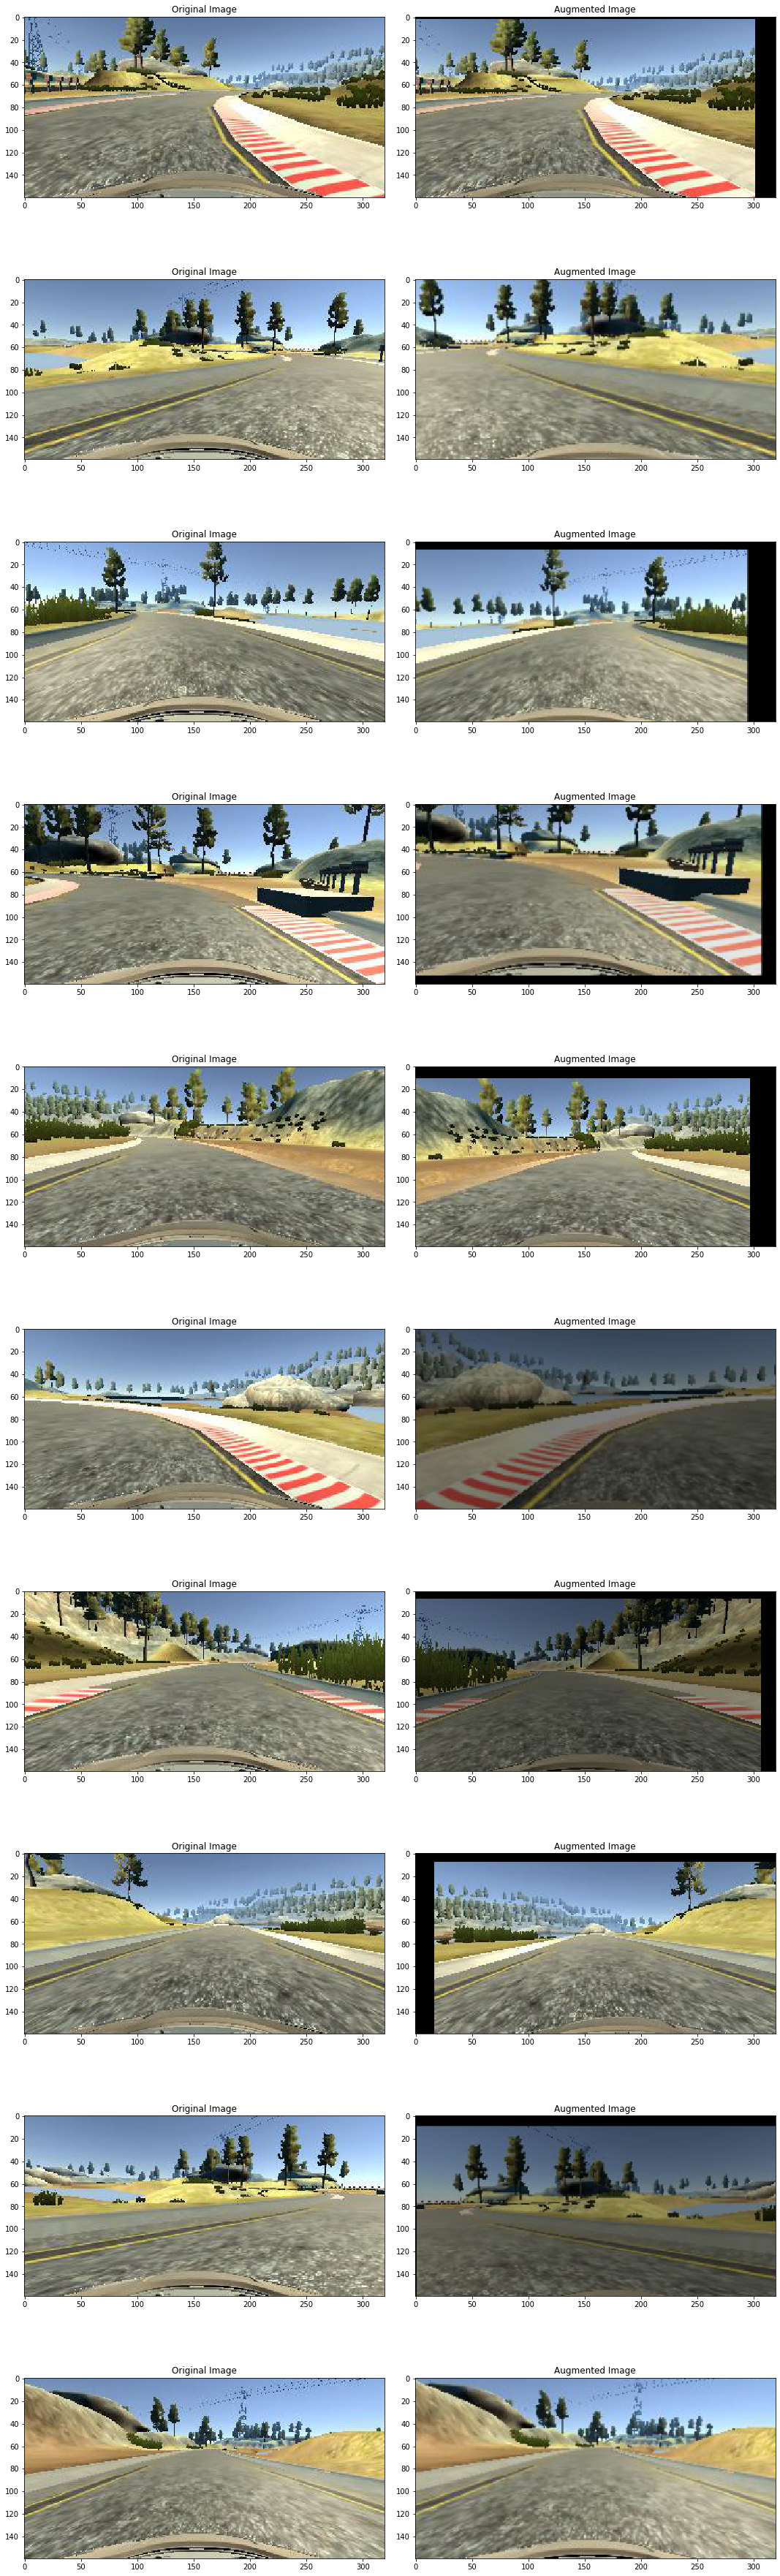

In [0]:
# Image Augmentation Examples and Test Visualizations
ncol = 2
nrow = 10
fig, axs = plt.subplots(nrow, ncol, figsize=(15, 50))
fig.tight_layout()

# selecting a random image to augment for each of the 10 grid cells
for i in range(10):
  randnum = random.randint(0, len(image_paths)-1)
  random_image = image_paths[randnum]
  random_steering = steerings[randnum]

  original_image = mpimg.imread(random_image)
  augmented_image, steering = random_augment(random_image, random_steering)

  axs[i][0].imshow(original_image)
  axs[i][0].set_title('Original Image')
  axs[i][1].imshow(augmented_image)
  axs[i][1].set_title('Augmented Image')

In [0]:
# preprocessing data and preparing it for use
def img_preprocess(img):
  # removing noise by cropping image (removing scenery, car hood, etc)
  img = img[60:135, :, :]
  img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
  # Gaussian blur smoothes out an image and reduces its noise
  img = cv2.GaussianBlur(img, ksize=(3, 3), sigmaX=0)
  # decreasing image size allows for faster computation
  img = cv2.resize(img, (200, 66))
  img = img / 255
  return img

In [0]:
# generates batches of randomly augmented images based on a specified batch size indicated by the batch_sizeparamter
# purpose of istraining boolean: training data can be augmented to help generalize model, but validation model should be kept as similar as possible to test data 
# this function is coroutine, using yield instead of return - saves all the local variables in the function and while loop resets when function is revisited
def batch_generator(image_paths, steering_ang, batch_size, istraining):
  while True:
    # stores newly augmented images and steering angles
    batch_img = []
    batch_steering = []

    for i in range(batch_size):
      random_index = random.randint(0, len(image_paths) - 1)

      if istraining:
        im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
      else:
        # the parameter img is a path, so mpimg returns the actual image inside the path
        im = mpimg.imread(image_paths[random_index])
        steering = steering_ang[random_index]

      im = img_preprocess(im)
      batch_img.append(im)
      batch_steering.append(steering)
    
    yield (np.asarray(batch_img,), np.asarray(batch_steering))

Text(0.5, 1, 'Validation image')

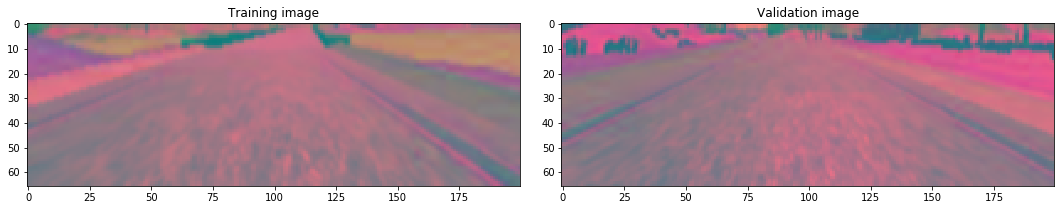

In [0]:
# used to request the next batch of images from the generator, next calls an iterator that retrieves the next item
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_valid_gen, y_valid_gen = next(batch_generator(X_valid, y_valid, 1, 0))

fig, axs = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axs[0].imshow(x_train_gen[0])
axs[0].set_title('Training image')
axs[1].imshow(x_valid_gen[0])
axs[1].set_title('Validation image')

Text(0.5, 1, 'Preprocessed Image')

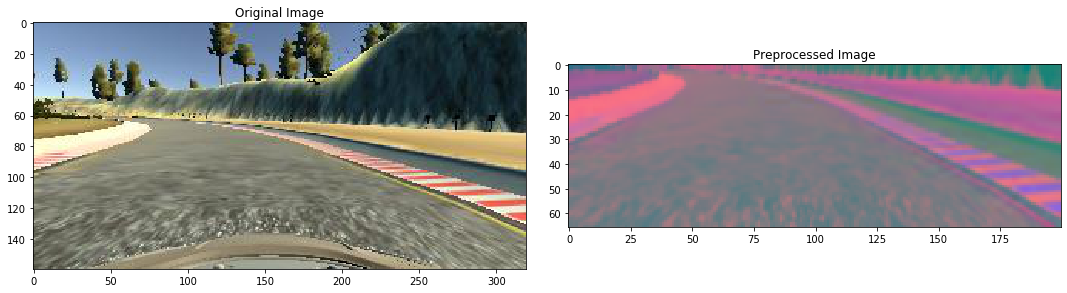

In [0]:
image = image_paths[5]
original_image = mpimg.imread(image)
preprocessed_image = img_preprocess(original_image)

fig, axes = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[1].imshow(preprocessed_image)
axes[1].set_title("Preprocessed Image")

In [0]:
# storing preprocessed X_train data set
# map loops through entire array and returns a new element based on specified function
# X_train = np.array(list(map(img_preprocess, X_train)))
# X_valid = np.array(list(map(img_preprocess, X_valid)))

In [0]:
# plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
# print(X_train.shape) # 1152 images, 66 height, 200 width, 3 color channels

In [0]:
# behavorial cloning model: Nvidia

def nvidia_model():
  model = Sequential()

  # First Conv2D layer: 24 filters, 5 x 5 kernel, subsample = stride of kernel
  # activation = elu - relu has a zero gradient in the negative region, while the elu has a non-zero gradient, avoiding the dead relu phenomenon
  model.add(Convolution2D(24, (5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
  model.add(Convolution2D(36, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Convolution2D(48, (5, 5), strides=(2, 2), activation='elu'))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  # model.add(Dropout(0.5))
  model.add(Convolution2D(64, (3, 3), activation='elu'))
  # model.add(Dropout(0.5))

  model.add(Flatten())
  # First Dense (fully connected) layer: 100 nodes
  model.add(Dense(100, activation='elu'))
  # model.add(Dropout(0.5))
 
  model.add(Dense(50, activation='elu'))
  # model.add(Dropout(0.5))
 
  model.add(Dense(10, activation='elu'))
  # model.add(Dropout(0.5))
  
  model.add(Dense(1))
  optimizer = Adam(lr=1e-4)
  model.compile(optimizer=optimizer, loss='mse')
  
  return model

In [0]:
model = nvidia_model()
print(model.summary())





Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)          

In [0]:
history = model.fit_generator(batch_generator(X_train, y_train, 100, 1), 
                              steps_per_epoch=300,
                              epochs=10, 
                              validation_data=batch_generator(X_valid, y_valid, 100, 0), 
                              validation_steps=200, 
                              verbose=1, 
                              shuffle=1)




Epoch 1/10





300/300 [==============================] - 182s 607ms/step - loss: 0.0772 - val_loss: 0.0563
Epoch 2/10
300/300 [==============================] - 176s 587ms/step - loss: 0.0632 - val_loss: 0.0517
Epoch 3/10
300/300 [==============================] - 176s 588ms/step - loss: 0.0587 - val_loss: 0.0543
Epoch 4/10
300/300 [==============================] - 177s 589ms/step - loss: 0.0546 - val_loss: 0.0443
Epoch 5/10
300/300 [==============================] - 178s 593ms/step - loss: 0.0501 - val_loss: 0.0442
Epoch 6/10
300/300 [==============================] - 179s 597ms/step - loss: 0.0473 - val_loss: 0.0383
Epoch 7/10
300/300 [==============================] - 179s 595ms/step - loss: 0.0432 - val_loss: 0.0394
Epoch 8/10
300/300 [==============================] - 179s 597ms/step - loss: 0.0409 - val_loss: 0.0385
Epoch 9/10
300/300 [==============================] - 178s 595ms/step - loss: 0.0394 - val_loss: 0.0368
Epoch 10/10
300/300 [==============================] - 1

Text(0.5, 0, 'Epoch')

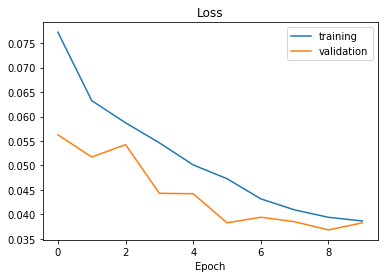

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

In [0]:
model.save('model.h5')

In [0]:
from google.colab import files
files.download('model.h5')